<a href="https://colab.research.google.com/github/ak1909552/Artificial-Neural-Networks/blob/main/assignments/assignment2/AbhigyanKishor_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as mp

## The MNIST_MLP class

This class is responsible for implementing an MLP network with dropout layers for each hidden layer. The output layer is a softmax layer.

In [ ]:
class MNIST_MLP(nn.Module):
    
    def __init__(self, layer_sizes=[784, 10], activation=None, drop = 0.0):
        super().__init__()
        self.layer_sizes = layer_sizes 
        
        # Different activations that you can use in forward() method.
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.identity = nn.Identity()

        self.dropout = nn.Dropout(p = drop)

        '''
        self.activation is the activation function determined by the constructor argument
        Defaults to self.relu
        '''
        
        if activation == 'sigmoid':
            self.activation = self.sigmoid
        elif activation == 'tanh':
            self.activation = self.tanh
        elif activation == 'identity':
            self.activation = self.identity
        else:
            self.activation = self.relu

        '''
        self.network represents the neural network to be constructed. 

        nn.Sequential accepts ordered dictionaries (dictionaries with the order of keys preserved)
        to create a stacked network. 

        The structure of self.layer_dict is as follows:
        {
            'layer<i>' : nn.Linear(dim<i>, dim<i+1>),
            'activation<i>' : self.activation,
            ...
        }

        The final layer is a nn.Softmax() on dimension 1 of the final nn.Linear() layer.
        '''
        
        self.layer_dict = OrderedDict()

        for i in range(len(layer_sizes) - 1):
            if(i == len(layer_sizes) - 2):
                self.layer_dict[f'dropout'] = self.dropout
            self.layer_dict[f'layer{i}'] = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            self.layer_dict[f'activation{i}'] = self.activation
        #   self.layer_dict[f'dropout{i}'] = self.dropout
        
        # del self.layer_dict[f'dropout{len(layer_sizes) - 2}']
        self.layer_dict[f'activation{len(layer_sizes) - 2}'] = nn.Softmax(1)

        self.network = nn.Sequential(self.layer_dict) 

    
    def forward(self, input):

        '''
        The forward pass remains the same, and looks very clean :)
        '''
        input = input.view(-1, self.layer_sizes[0])
        # Switch from activation maps to vectors
        x = self.network(input)
        return x
    
    # This function maps the network on the device that is passed as argument.
    # If your device doesn't have a GPU, it set device='cpu'.
    def set_device(self, device):
        self.device = device
        self.to(self.device)
    
    # This function trains the model on the data passed as arguments.        


    def fit(self, mnist_train_loader, num_epochs=1, mnist_valid_loader=None):
        train_loss_history = []
        train_acc_history = []
        valid_loss_history = []
        valid_acc_history = []
        
        for epoch in range(num_epochs):
            
            self.train() # Set to the training mode.
            iter_loss = 0
            iter_acc = 0
            for i, (items, classes) in enumerate(mnist_train_loader):
                items = Variable(items).to(self.device)
                classes = Variable(classes).to(self.device)

                self.optimizer.zero_grad()     # Clear off the gradients from any past operation
                outputs = self.forward(items)      # Do the forward pass
                loss = self.criterion(outputs, classes) # Calculate the loss
                loss.backward()           # Calculate the gradients with help of back propagation
                self.optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
                iter_loss += loss.data # Accumulate the loss
                iter_acc += (torch.max(outputs.data, 1)[1] == classes.data).sum()
                print("\r", i + 1, "/", len(mnist_train_loader), ", Loss: ", loss.data/len(items), end="")
            train_loss_history += [iter_loss.cpu().detach().numpy()]
            train_acc_history += [(iter_acc/len(mnist_train_loader.dataset)).cpu().detach().numpy()]
            print("\tTrain: ", train_loss_history[-1], train_acc_history[-1], end="")
            
            self.eval() # Set to the evaluation mode.
            iter_loss = 0
            iter_acc = 0
            for i, (items, classes) in enumerate(mnist_valid_loader):
                items = Variable(items).to(self.device)
                classes = Variable(classes).to(self.device)

                outputs = self(items)      # Do the forward pass
                iter_loss += self.criterion(outputs, classes).data
                iter_acc += (torch.max(outputs.data, 1)[1] == classes.data).sum()
            valid_loss_history += [iter_loss.cpu().detach().numpy()]
            valid_acc_history += [(iter_acc/len(mnist_valid_loader.dataset)).cpu().detach().numpy()]
            print("\tValidation: ", valid_loss_history[-1], valid_acc_history[-1])
        
        return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history



## The `mnist_loader()` function

In [ ]:
def mnist_loader(batch_size=512, classes=None):
    transform=transforms.Compose([transforms.ToTensor()])
    mnist_train = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    mnist_valid = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    
    # Select the classes which you want to train the classifier on.
    if classes is not None:
        mnist_train_idx = (mnist_train.targets == -1)
        mnist_valid_idx = (mnist_valid.targets == -1)
        for class_num in classes:
            mnist_train_idx |= (mnist_train.targets == class_num)
            mnist_valid_idx |= (mnist_valid.targets == class_num) 
        
        mnist_train.targets = mnist_train.targets[mnist_train_idx]
        mnist_valid.targets = mnist_valid.targets[mnist_valid_idx]
        mnist_train.data = mnist_train.data[mnist_train_idx]
        mnist_valid.data = mnist_valid.data[mnist_valid_idx]
    
    mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)
    return mnist_train_loader, mnist_valid_loader

## Setting the device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## A. Number of Parameters

In [ ]:
model = MNIST_MLP(layer_sizes=[784, 392, 196, 49, 25, 10], activation='relu')

product = 1
for l in model.layer_sizes:
    product = product * l

print(product)

737894528000


## B. Running the model

 1. Without dropout

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

 118 / 118 , Loss:  tensor(0.0209, device='cuda:0')	Train:  263.37326 0.3438	Validation:  41.14199 0.45279998
 118 / 118 , Loss:  tensor(0.0193, device='cuda:0')	Train:  228.92891 0.5611	Validation:  37.332226 0.6164
 118 / 118 , Loss:  tensor(0.0189, device='cuda:0')	Train:  217.87805 0.62808335	Validation:  36.836807 0.6271
 118 / 118 , Loss:  tensor(0.0180, device='cuda:0')	Train:  216.13303 0.63490003	Validation:  36.628162 0.6344
 118 / 118 , Loss:  tensor(0.0185, device='cuda:0')	Train:  215.34198 0.6393667	Validation:  36.54187 0.63629997
 118 / 118 , Loss:  tensor(0.0189, device='cuda:0')	Train:  213.92853 0.6469833	Validation:  36.089146 0.655
 118 / 118 , Loss:  tensor(0.0187, device='cuda:0')	Train:  210.0538 0.69715	Validation:  35.319324 0.7206
 118 / 118 , Loss:  tensor(0.0179, device='cuda:0')	Train:  205.80109 0.7363667	Validation:  34.795647 0.7362
 118 / 118 , Loss:  tensor(0.0175

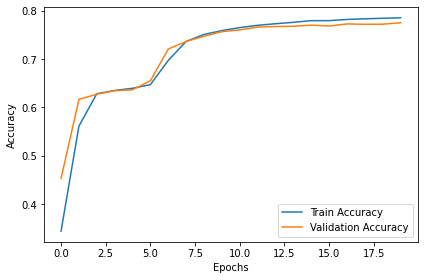

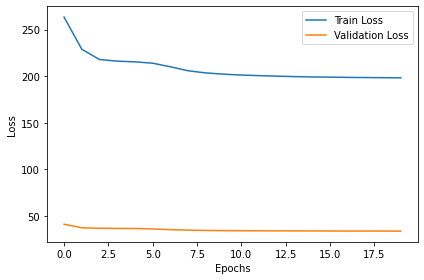

In [ ]:
batch_size = 512
mnist_train_loader, mnist_valid_loader = mnist_loader(batch_size=batch_size)
model.set_device(device)
# Our loss function and Optimizer

model.criterion = nn.CrossEntropyLoss()
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr is the learning_rate
# Train model for 20 epochs
tlh, tah, vlh, vah = model.fit(mnist_train_loader, num_epochs=20, mnist_valid_loader=mnist_valid_loader)

plt.figure()
plt.plot(tah, label='Train Accuracy')
plt.plot(vah, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.savefig('PartB_accuracy')

plt.figure()
plt.plot(tlh, label='Train Loss')
plt.plot(vlh, label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.savefig('PartB_Loss')

about 78% - 80% accuracy reported here.

2. Further training..

 118 / 118 , Loss:  tensor(0.0178, device='cuda:0')	Train:  198.01396 0.7866667	Validation:  33.773453 0.7743
 118 / 118 , Loss:  tensor(0.0170, device='cuda:0')	Train:  197.7906 0.788	Validation:  33.73998 0.7772
 118 / 118 , Loss:  tensor(0.0163, device='cuda:0')	Train:  197.57086 0.78903335	Validation:  33.68575 0.77849996
 118 / 118 , Loss:  tensor(0.0169, device='cuda:0')	Train:  197.45232 0.7912667	Validation:  33.690197 0.77849996
 118 / 118 , Loss:  tensor(0.0172, device='cuda:0')	Train:  197.323 0.79193336	Validation:  33.66306 0.7797
 118 / 118 , Loss:  tensor(0.0171, device='cuda:0')	Train:  197.1448 0.79358333	Validation:  33.666424 0.7801
 118 / 118 , Loss:  tensor(0.0169, device='cuda:0')	Train:  197.08745 0.7939	Validation:  33.6285 0.7805
 118 / 118 , Loss:  tensor(0.0177, device='cuda:0')	Train:  196.98618 0.7949833	Validation:  33.641983 0.7808
 118 / 118 , Loss:  tensor(0.0175, device='cuda:0')	Train:  196.8226 0.79620004	Validation:  33.596966 0.7823
 118 / 118 , Lo

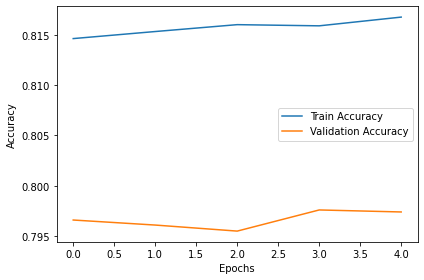

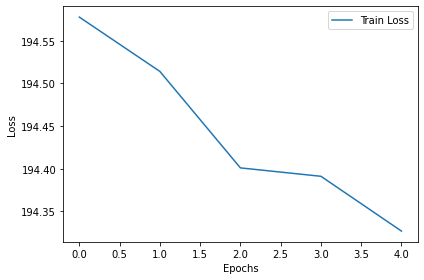

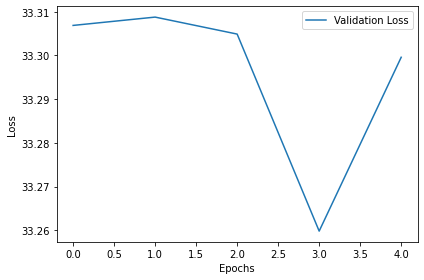

In [ ]:
model.criterion = nn.CrossEntropyLoss()
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr is the learning_rate
model.fit(mnist_train_loader, num_epochs=40, mnist_valid_loader=mnist_valid_loader)
tlh, tah, vlh, vah = model.fit(mnist_train_loader, num_epochs=5, mnist_valid_loader=mnist_valid_loader)

plt.figure()
plt.plot(tah, label='Train Accuracy')
plt.plot(vah, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.savefig('PartB_accuracy')

plt.figure()
plt.plot(tlh, label='Train Loss')
# plt.plot(vlh, label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.savefig('PartB_Loss')

plt.figure()
# plt.plot(tlh, label='Train Loss')
plt.plot(vlh, label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.savefig('PartB_Loss')

These are signs of overfitting, where training accuracy is going up but validation loss is erratic.

3. With dropout




 drop = 0.2
 118 / 118 , Loss:  tensor(0.0214, device='cuda:0')	Train:  261.94424 0.27625	Validation:  40.825066 0.5003
 118 / 118 , Loss:  tensor(0.0198, device='cuda:0')	Train:  232.28758 0.5212833	Validation:  37.799007 0.57809997
 118 / 118 , Loss:  tensor(0.0190, device='cuda:0')	Train:  218.35342 0.63285	Validation:  35.761288 0.6768
 118 / 118 , Loss:  tensor(0.0182, device='cuda:0')	Train:  211.28653 0.6849667	Validation:  35.100643 0.7227
 118 / 118 , Loss:  tensor(0.0183, device='cuda:0')	Train:  207.26321 0.72693336	Validation:  34.422176 0.7572
 118 / 118 , Loss:  tensor(0.0181, device='cuda:0')	Train:  204.26593 0.7478	Validation:  34.069233 0.76989996
 118 / 118 , Loss:  tensor(0.0178, device='cuda:0')	Train:  202.40997 0.7594167	Validation:  33.82787 0.777
 118 / 118 , Loss:  tensor(0.0173, device='cuda:0')	Train:  201.09203 0.7683	Validation:  33.70569 0.7813
 118 / 118 , Loss:  tensor(0.0178, device='cuda:0')	Train:  200.27446 0.7737	Validation:  33.674904 0.783
 118 

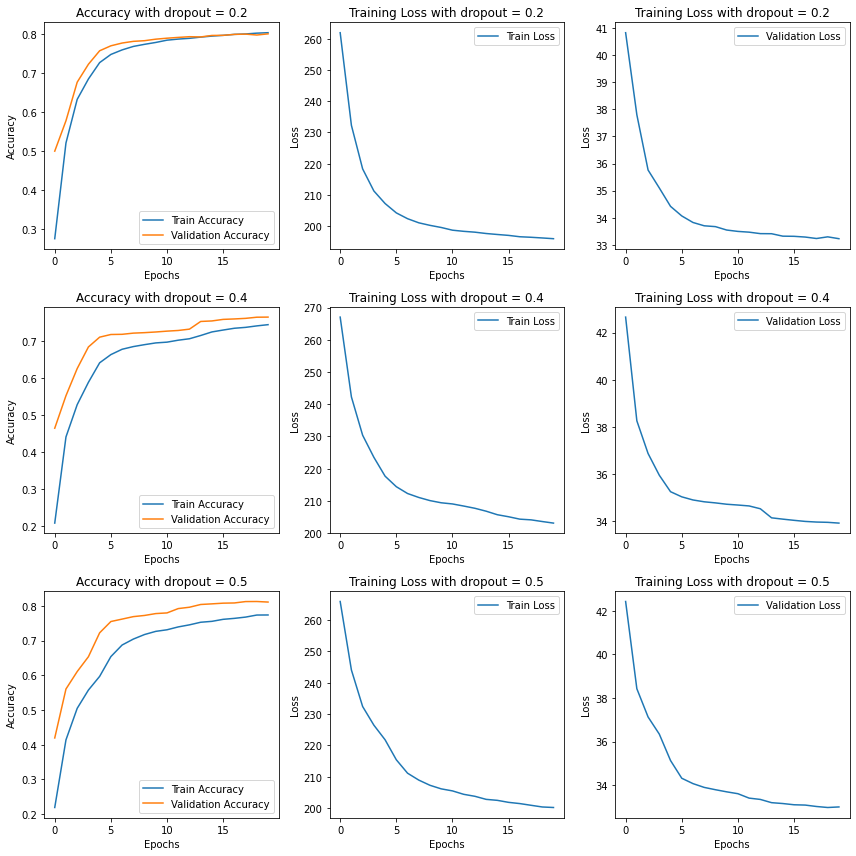

In [ ]:
batch_size = 512
mnist_train_loader, mnist_valid_loader = mnist_loader(batch_size=batch_size)



drops = [0.2, 0.4, 0.5]
figure = plt.figure(figsize=(12, 12))
rows, cols = (3,3)
for i, d in enumerate(drops):
    print(f'\n drop = {d}')
    model_drop = MNIST_MLP(layer_sizes=[784, 392, 196, 49, 25, 10], activation='relu', drop = d)
    model_drop.set_device(device)
    # Our loss function and Optimizer

    model_drop.criterion = nn.CrossEntropyLoss()
    model_drop.optimizer = torch.optim.Adam(model_drop.parameters(), lr=0.0001) #lr is the learning_rate
    # Train model for 20 epochs
    tlh, tah, vlh, vah = model_drop.fit(mnist_train_loader, num_epochs=20, mnist_valid_loader=mnist_valid_loader)

    figure.add_subplot(rows,cols, cols*i + 1)
    
    plt.title(f'Accuracy with dropout = {d}')
    plt.plot(tah, label='Train Accuracy')
    plt.plot(vah, label='Validation Accuracy')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.tight_layout()


    figure.add_subplot(rows,cols, cols*i + 2)

    plt.title(f'Training Loss with dropout = {d}')
    plt.plot(tlh, label='Train Loss')
    # plt.plot(vlh, label='Validation Loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.tight_layout()

    figure.add_subplot(rows,cols, cols*i + 3)

    plt.title(f'Training Loss with dropout = {d}')
    # plt.plot(tlh, label='Train Loss')
    plt.plot(vlh, label='Validation Loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.tight_layout()

plt.show()




The models consistantly reach 80% and above accuracies. With dropout, training time must increase to compensate for the regularization methods. Therefor dropout gives us very good model accuracies.

4. Visualizing the output

The titles indicate the labels in the following order:
- MLP (without dropout)
- MLP (dropout = 0.5)
- truth

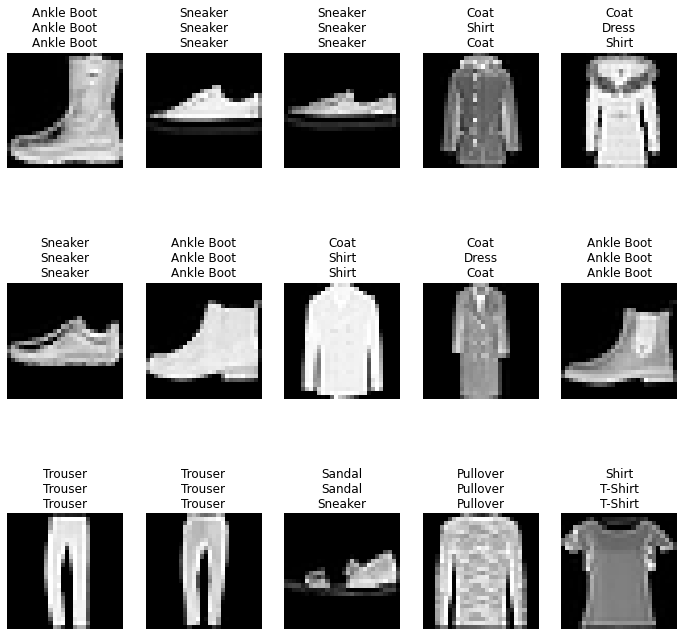

In [ ]:
import numpy as np
transform=transforms.Compose([transforms.ToTensor()])
training_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)




labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(12, 12))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img = Variable(img).to(device)
    
    output = model(img)
    output_drop = model_drop(img)

    output = output.cpu().detach().numpy()
    output_drop = output_drop.cpu().detach().numpy()

    figure.add_subplot(rows, cols, i)
    plt.title(f'{labels_map[label]}\n{labels_map[np.argmax(output)]}\n{labels_map[np.argmax(output_drop)]}')
    plt.axis("off")
    plt.imshow(img.cpu().detach().numpy().squeeze(), cmap="gray")
plt.show()
